# Graph Representation Learning practicum

## 1. Installing the environment
First we need to install the relevant packages, copy paste the following commands in the terminal :
```
conda create -n grl_prac python=3.9
conda activate grl_prac
pip install NetworkAnalysis
pip install OpenNe
pip install gensim
pip install tensorflow_ranking
pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
pip install torch_geometric
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
```

In [1]:
import random
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import torch

from keras.models import Model
from keras.layers import Embedding, Input, Dense, Dropout, Lambda
from sklearn.metrics import roc_auc_score, average_precision_score
from NetworkAnalysis.UndirectedInteractionNetwork import UndirectedInteractionNetwork

2023-05-04 12:04:55.369525: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 12:04:55.414529: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 12:04:55.415449: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 12:04:57.408861: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 2. Toy example
karate network

In [ ]:
# Read in network
karate_nw = pd.read_csv("data/karate.txt", sep=' ', header=None, names=['GeneA', 'GeneB'])
print(karate_nw.head())

In [ ]:
karate_obj = UndirectedInteractionNetwork(karate_nw, keeplargestcomponent=True)

In [ ]:
communities = nx.community.louvain_communities(karate_obj.getnxGraph(), resolution=1, seed=23)
comm_dict = {f"group_{i}": c for i, c in enumerate(communities)}
comm_dict = {i:k for k, v in comm_dict.items() for i in v}
color_map = {"group_0": "blue", "group_1": "red", "group_2": "green", "group_3": "purple"}

In [ ]:
karate_obj.visualize(show_labels=True,
                     node_colors=[color_map[comm_dict[gene]] for gene in karate_obj.getnxGraph().nodes], cmap='spectral',
                     title="Karate Communities",
                     color_scheme_edges=('gray', 'tab:green'),
                     labels_dict=None,
                     filename=None,
                     save_path=None)

In [ ]:
embeddings = karate_obj.generateEmbeddings(method='DeepWalk', dimensions=2, epochs=10)

In [ ]:
df = pd.DataFrame(embeddings, index=['dim1', 'dim2']).transpose()
df['group'] = [comm_dict[gene] for gene in df.index]
print(df.head())

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
sns.scatterplot(data=df, x='dim1', y='dim2', hue='group', ax=ax1, palette=color_map, s=100)
for i in range(df.shape[0]):
 ax1.text(x=df.dim1[i]+0.01,y=df.dim2[i]+0.01,s=df.index[i], 
          fontdict=dict(color='black',size=10))
ax1.set_title("Embeddings of karate network")
plt.show()

## 3. Link Prediction on PPI scaffold
Using a deep learning network written in TensorFlow (gcn will be in pytorch)

In [ ]:
reactome = pd.read_csv("data/reactome.txt", header=0, sep=None)
print(reactome.head())

In [ ]:
reactome_obj = UndirectedInteractionNetwork(reactome, keeplargestcomponent=False)

In [ ]:
mst_reactome = reactome_obj.getMinimmumSpanningTree()
print(len(mst_reactome))

In [ ]:
# Otherwise training will take too long
pos_edges = set([tuple(i) for i in reactome_obj.getInteractionNamed().values]) - set(mst_reactome)
final_edges = mst_reactome + random.sample(list(pos_edges), k=25_000)
reactome_reduced_obj = UndirectedInteractionNetwork(pd.DataFrame(final_edges))


### Edge sampling strategies
Why do we need MST?
Why do we need NPR?
In words explain the sampling strategy

In [ ]:
# X_train, X_test, Y_train, Y_test, summary_df = reactome_reduced_obj.getTrainTestData(train_ratio=0.8, neg_pos_ratio=5, 
#                                                                             train_validation_ratio=None, excluded_sets=None,
#                                                                             return_summary=True, random_state=42, balanced=False,
#                                                                             include_negatives=None, verbose=True)

X_train, X_test, Y_train, Y_test, summary_df = reactome_obj.getTrainTestData(train_ratio=0.8, neg_pos_ratio=5, 
                                                                            train_validation_ratio=None, excluded_sets=None,
                                                                            return_summary=True, random_state=42, balanced=False,
                                                                            include_negatives=None, verbose=True)


Explain how we will build the model, its important they understand we also need EDGE representations to do link prediction.
In formula show the 4 different binary operators they can use, they must themself implement (almost the entire architecture)

In [ ]:
from DeepLinkPrediction.DLembedder import DLembedder
dl_net = DLembedder(reactome_obj.N_nodes, 10, nodes_per_layer=[32, 32, 1],
                        activations_per_layer=['relu', 'relu', 'sigmoid'], int2genedict=None,
                        dropout=0.2, merge_method='hadamard', random_state=23, BatchNorm=False)
print(dl_net.model.summary())
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=0, mode='auto')
_ = dl_net.fit(X_train, Y_train, validation_split=0.2, callbacks=[earlyStopping],
                       n_epochs=10, verbose=1, allow_nans=False, metrics='binary_accuracy',
                       loss='binary_crossentropy', predefined_embeddings=None, freeze_embedding=False,
                       lossWeights=None)


In [ ]:
# Define model parameters
N_nodes = reactome_obj.N_nodes
seq_length = 2
embed_dim = 10
hidden_nodes = 32
dropout = 0.2
final_activation = 'sigmoid'

# Define model architecture
embedding_layer = Embedding(input_dim=N_nodes, output_dim=embed_dim, input_length=seq_length, name='Embedder')
sequence_input = Input(shape=(seq_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
edge_rep = Lambda(lambda x:  x[:, 0] * x[:, 1], output_shape=[embed_dim], name='edge_representation')(embedded_sequences)

x = Dense(hidden_nodes, activation='relu')(edge_rep)
x = Dropout(dropout)(x)
x = Dense(hidden_nodes, activation='relu')(x)
x = Dropout(dropout)(x)
preds = Dense(1, activation=final_activation)(x)

# Declare model in Keras and print the model 
model = Model(inputs=sequence_input, outputs=preds)
print(model.summary())

In [ ]:
# Now we will train the model
loss = tf.keras.losses.binary_crossentropy
metrics = tf.keras.metrics.binary_accuracy
optimizer = tf.optimizers.Adam()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [ ]:
n_epochs = 10
validation_split = 0.2
batch_size = 32
verbose = 1

idx = np.random.permutation(Y_train.shape[0])
X_train = X_train[idx]
Y_train = Y_train[idx]
history = model.fit(x=X_train, y=Y_train, epochs=n_epochs, validation_split=validation_split, batch_size=batch_size, verbose=verbose)

In [ ]:
# Plot (val) loss and (val) binary accuracy and assess if the curves are correct


In [ ]:
test_preds = model.predict(X_test)
auc, ap = roc_auc_score(y_true=Y_test, y_score=test_preds), average_precision_score(y_true=Y_test, y_score=test_preds)
print(f"Prediciton performance on test set: {auc*100:.3f} AUC - {ap*100:.3f} Average Precision")

## 4. Node classification using GCNs/GATs
Based on the google collab by PyTorch geometric: https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

# Print information about the graph 
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Is undirected: {data.is_undirected()}')

# Think about the size of the feature matrix and adjancency matrix and check by printing the data object
print(data)

# Print a part of the feature matrix
data.x



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Is undirected: True
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Now we see that the object contains all the relevant information, in addition to the basics is contains a `val_mask` and a `test_mask`, these masks highlight the nodes that we will use for validation and testing respectively.
Before we start building the model take some time to analyze the feature matrix, note that the original features are bag-of-words (BOW) vectors for each. This means that each featurer is a word and thus $x_{ij}$ represent the number of times $word_{j}$ occurs in $publication_i$ (or $sample_i$). Often in ML or DL when gradient descent (GD) algoritms are used to optimze the objective function, GD will converge faster if all features have the same scale, i.e. are normalized. Check how the feature matrix is normalized and reason why this is done a particular way and identify the function in pytorch geometric that could perform this operation.

Explain why self loops are necessary

Explain the general layout of the mdoel they need to code and let them realize they are outputting the EMBEDDING and still need to compute the cross entropy loss and 

In [3]:
import torch_geometric.nn as geom_nn
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, **kwargs):
        super().__init__()

        # Define GCN layers

        self.gcn1 = geom_nn.GCNConv(in_channels=in_features, out_channels=hidden_features, **kwargs) # add self loops default true
        self.gcn2 = geom_nn.GCNConv(in_channels=hidden_features, out_channels=out_features, **kwargs)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # layer 1
        x= self.gcn1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # layer 2
        output = self.gcn2(x, edge_index)

        return output

Explain the train test loop and the steps in pseudcode

In [4]:
model = GCN(in_features=data.x.shape[1], hidden_features=16, out_features=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


/tmp/ipykernel_19359/1946117309.py:16: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(data=cora_df, x='dim1', y='dim2', hue='group', palette=sns.color_palette('tab10'), ax=ax1, s=50)


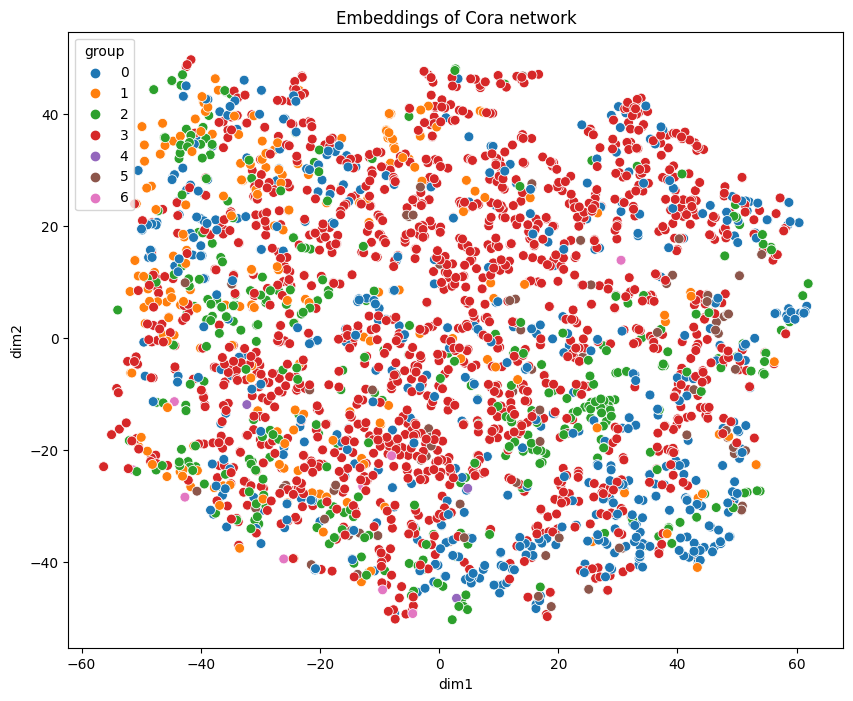

In [6]:
# Visualize the embeddings colored by category
from sklearn.manifold import TSNE

# 1. Get all categories 
categories = model(data).argmax(dim=1).detach().numpy()

# 2. Perform TSNE on the embeddings 
tsne_ = TSNE()
dims = tsne_.fit_transform(model(data).detach().numpy())

# 3. Put everyting together in a dataframe
cora_df = pd.DataFrame({"dim1":dims[:, 0], "dim2":dims[:, 1], "group":categories})

# 4. Plot
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
sns.scatterplot(data=cora_df, x='dim1', y='dim2', hue='group', palette=sns.color_palette('tab10'), ax=ax1, s=50)
ax1.set_title("Embeddings of Cora network")
plt.show()

In [7]:
# Train the network
for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9460
Epoch: 002, Loss: 1.9423
Epoch: 003, Loss: 1.9373
Epoch: 004, Loss: 1.9324
Epoch: 005, Loss: 1.9255
Epoch: 006, Loss: 1.9168
Epoch: 007, Loss: 1.9099
Epoch: 008, Loss: 1.9044
Epoch: 009, Loss: 1.8925
Epoch: 010, Loss: 1.8810
Epoch: 011, Loss: 1.8726
Epoch: 012, Loss: 1.8652
Epoch: 013, Loss: 1.8445
Epoch: 014, Loss: 1.8470
Epoch: 015, Loss: 1.8272
Epoch: 016, Loss: 1.8069
Epoch: 017, Loss: 1.8027
Epoch: 018, Loss: 1.7862
Epoch: 019, Loss: 1.7797
Epoch: 020, Loss: 1.7633
Epoch: 021, Loss: 1.7409
Epoch: 022, Loss: 1.7337
Epoch: 023, Loss: 1.7100
Epoch: 024, Loss: 1.6992
Epoch: 025, Loss: 1.6814
Epoch: 026, Loss: 1.6742
Epoch: 027, Loss: 1.6622
Epoch: 028, Loss: 1.6280
Epoch: 029, Loss: 1.6030
Epoch: 030, Loss: 1.5847
Epoch: 031, Loss: 1.5711
Epoch: 032, Loss: 1.5336
Epoch: 033, Loss: 1.5377
Epoch: 034, Loss: 1.5025
Epoch: 035, Loss: 1.5047
Epoch: 036, Loss: 1.4761
Epoch: 037, Loss: 1.4565
Epoch: 038, Loss: 1.4512
Epoch: 039, Loss: 1.3916
Epoch: 040, Loss: 1.3794


Do you notice anything strange or missing in the testing loop? -> no softmax so the output are not probabilities but embeddings, for the performance calculation it is no problem but for interpretation we need to apply a softmax

In [ ]:
F.softmax(model(data))[0].argmax()

In [8]:
test_acc = test()
print(f"Testing accuracy is {test_acc*100:.2f}%")

Testing accuracy is 81.10%


/tmp/ipykernel_19359/2176713722.py:15: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(data=cora_df, x='dim1', y='dim2', hue='group', palette=sns.color_palette('tab10'), ax=ax1, s=50)


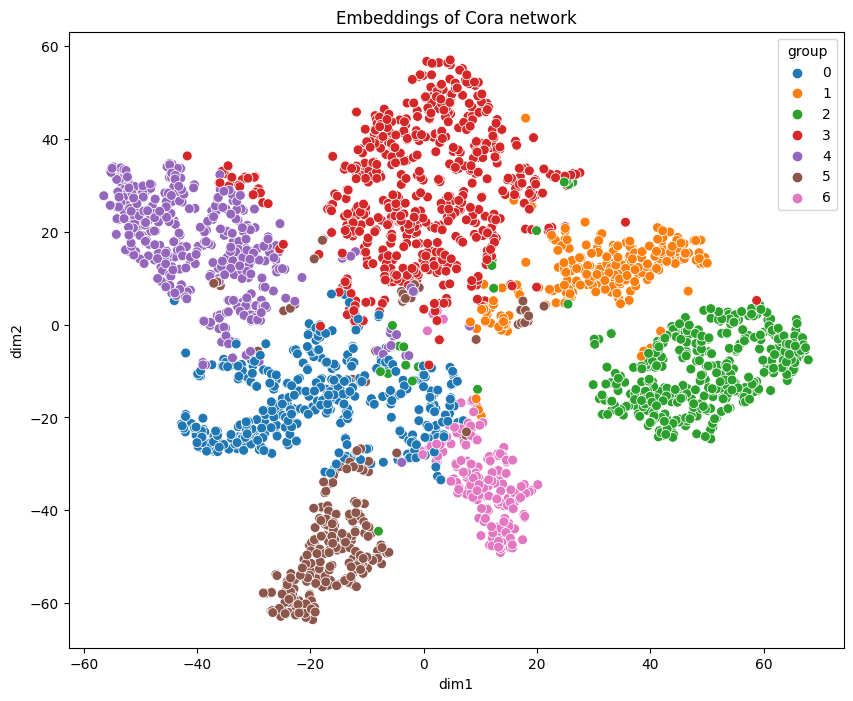

In [10]:
# Visualize the embeddings colored by category

# 1. Get all categories 
categories = model(data).argmax(dim=1).detach().numpy()

# 2. Perform TSNE on the embeddings 
tsne_ = TSNE()
dims = tsne_.fit_transform(model(data).detach().numpy())

# 3. Put everyting together in a dataframe
cora_df = pd.DataFrame({"dim1":dims[:, 0], "dim2":dims[:, 1], "group":categories})

# 4. Plot
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
sns.scatterplot(data=cora_df, x='dim1', y='dim2', hue='group', palette=sns.color_palette('tab10'), ax=ax1, s=50)
ax1.set_title("Embeddings of Cora network")
plt.show()